# Satellite coverage area calculator

This tutorial demonstrates how to calculate satellite coverage using Python and PySTK. It is inspired by [this training](https://help.agi.com/stk/Content/training/GetStart_7_Coverage.htm).

## What is satellite coverage?

Engineers and operators often need to determine the times that a satellite can "access" (or see) another object. Satellite coverage describes which areas of the Earth can access a satellite considering constraints defining what constitutes a valid access, including elevation angle, sun light or umbra restrictions, gimbal speed, range, and more. Satellite coverage can be calculated globally, or over a certain region.

## Problem statement

Two satellites present circular orbits. The first satellite has an inclination of $97.3^\circ$ and an altitude of $400$ km. The second satellite has a RAAN of $340^\circ$. Calculate the coverage these satellites provide over the tropics region of the Earth, defined as the area between the latitudes of $-23.5^\circ$ and $23.5^\circ$. Use a point resolution of $3.0^\circ$. Determine which satellite achieves higher coverage of the tropics region and if coverage is better or worse near the Equator. Finally, determine which areas of the tropics region receive coverage from both satellites at the same time.

## Launch a new STK instance

Start by launching a new STK instance. In this example, STKEngine is used.

In [1]:
from ansys.stk.core.stkengine import STKEngine


stk = STKEngine.start_application(no_graphics=False)
print(f"Using {stk.version}")

Using STK Engine v12.10.0


## Create a new scenario

Create a new scenario in STK by running:

In [2]:
root = stk.new_object_root()
root.new_scenario("Coverage")

Once the scenario is created, it is possible to show a 3D graphics window by running:

RFBOutputContext()

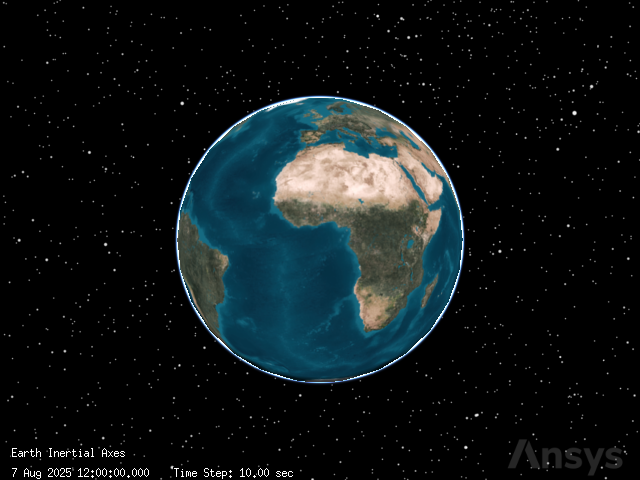

In [3]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import GlobeWidget


globe_plotter = GlobeWidget(root, 640, 480)
globe_plotter.show()

A 2D graphics window can be created to better visualize the satellite coverage area:

RFBOutputContext()

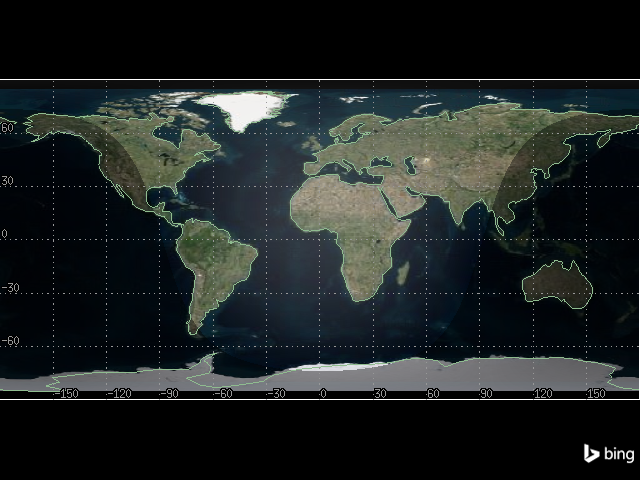

In [4]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import MapWidget


map_plotter = MapWidget(root, 640, 480)
map_plotter.show()

## Set the scenario time period

Using the newly created scenario, set the start and stop times. Rewind the scenario so that the graphics match the start and stop times of the scenario:

In [5]:
scenario = root.current_scenario
scenario.set_time_period("1 Jul 2016", "2 Jul 2016")
root.rewind()

## Add the satellites to the scenario

First, add a satellite in a polar orbit:

In [6]:
from ansys.stk.core.stkobjects import STKObjectType


polar_sat = root.current_scenario.children.new(STKObjectType.SATELLITE, "PolarSat")

Then, set the satellite's propagator to J4Pertubation:

In [7]:
from ansys.stk.core.stkobjects import PropagatorType


polar_sat.set_propagator_type(PropagatorType.J4_PERTURBATION)

The satellite should have a circular orbit with an inclination of $97.3^\circ$ and an altitude of $400$ km, which translates to an initial state of $r_x = -6374.80$ km, $r_y = -2303.27$ km, $r_z = -0.0000357827$ km, $v_x = -0.499065$ km/s, $v_y = 1.38127$ km/s, and $v_z = 7.6064$ km/s given with respect to J2000 frame:

In [8]:
from ansys.stk.core.stkobjects import CoordinateSystem


polar_sat_propagator = polar_sat.propagator
r_vec = [-6374.8, -2303.27, -0.0000357827]
v_vec = [-0.499065, 1.38127, 7.6064]
polar_sat_propagator.initial_state.representation.assign_cartesian(
    CoordinateSystem.J2000, *r_vec, *v_vec
)

Then, insert a satellite named Shuttle:

In [9]:
shuttle = root.current_scenario.children.new(STKObjectType.SATELLITE, "Shuttle")

Set the satellite's propagator to J4Pertubation:

In [10]:
shuttle.set_propagator_type(PropagatorType.J4_PERTURBATION)

The satellite should have a circular orbit with a RAAN of $340^\circ$, which translates to an initial state of $r_x = -6878.12$ km, $r_y = -16.3051$ km, $r_z = 0.00199559$ km, $v_x = -0.0115701$ km/s, $v_y = -4.88136$ km/s, and $v_z = 5.38292$ km/s with respect to the J2000 frame:

In [11]:
shuttle_propagator = shuttle.propagator
r_vec = [-6878.12, -16.3051, 0.00199559]
v_vec = [-0.0115701, -4.88136, 5.38292]
shuttle_propagator.initial_state.representation.assign_cartesian(
    CoordinateSystem.J2000, *r_vec, *v_vec
)

Finally, propagate both satellites:

In [12]:
polar_sat_propagator.propagate()
shuttle_propagator.propagate()

View their paths in 2D or 3D using the graphics widgets:

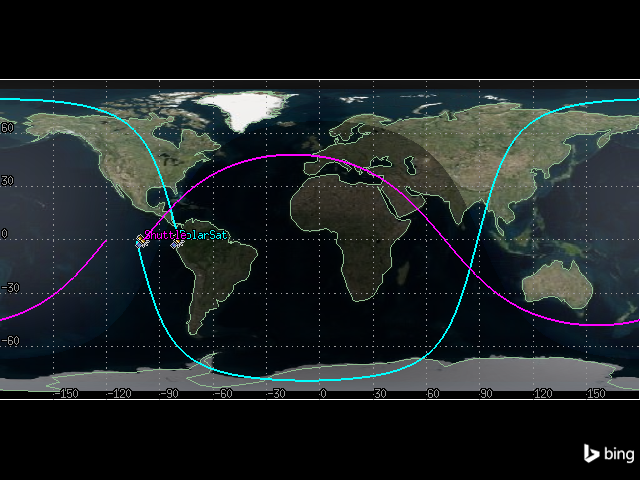

In [13]:
map_plotter.show()

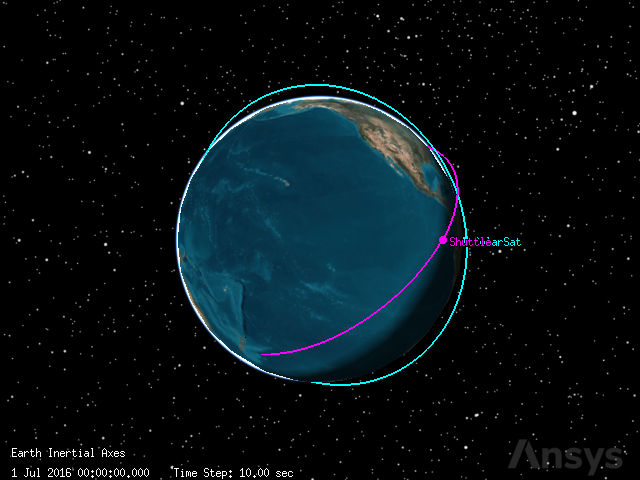

In [14]:
globe_plotter.show()

## Create a coverage definition

Create a coverage definition object modeling the region of Tropics:

In [15]:
tropics = root.current_scenario.children.new(
    STKObjectType.COVERAGE_DEFINITION, "Tropics"
)

Assign the coverage definition a grid of type latitude bounds, with a minimum latitude of $-23.5^\circ$, a maximum latitude of $23.5^\circ$, and point granularity of $3.0^\circ$ lat/lon:

In [16]:
from ansys.stk.core.stkobjects import CoverageBounds


tropics.grid.bounds_type = CoverageBounds.LATITUDE
tropics.grid.bounds.minimum_latitude = -23.5
tropics.grid.bounds.maximum_latitude = 23.5
tropics.grid.resolution.latitude_longitude = 3

### Assign the assets

Assign the satellites (PolarSat and Shuttle) as assets on the coverage definition. To do so, use a path to the satellites of the form ``ItemType/ItemName``.

In [17]:
tropics.asset_list.add("Satellite/PolarSat")
tropics.asset_list.add("Satellite/Shuttle")

### Configure the 2D graphics

Use the coverage definition's static property (which holds a ``ICoverageGraphics2DStatic`` object), to set the Show Regions, Show Region Labels, Show Points, and Points - Fill graphics properties.

In [18]:
tropics.graphics.static.show_region = True
tropics.graphics.static.show_labels = True
tropics.graphics.static.show_points = True
tropics.graphics.static.fill_points = True

To set the visibility for Progress of Computations, use a ``CoverageGraphics2DProgres``s object, which is available through the ``ICoverageGraphics`` object's ``progress`` property.

In [19]:
tropics.graphics.progress.show_graphics = True

To set the satisfaction visibility, use an ``ICoverageGraphics2DAnimation`` object, which is accessible through the ``ICoverageGraphics`` object's ``animation`` property.

In [20]:
tropics.graphics.animation_settings.show_satisfaction = False

View the coverage definition's graphics using the 2D graphics window:

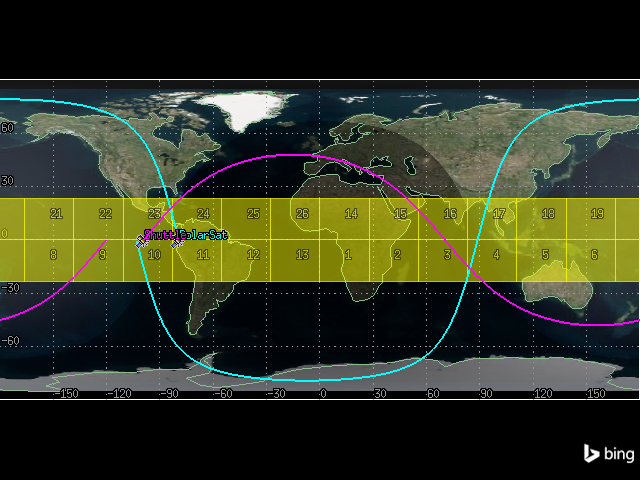

In [21]:
map_plotter.show()

## Compute coverage and create reports

Use the tropics coverage definition object to compute accesses:

In [22]:
tropics.compute_accesses()

### Create reports

To create reports, access the data providers associated with the coverage object. Then, select the type of report using the ``item`` method and the name of the report. The Coverage By Asset and Coverage by Latitude reports correspond to ``IDataProviderFixed`` objects. By using the ``exec`` method, compute the data needed for these reports. The ``exec`` method returns an ``IDataProviderResult`` object, through which it is possible to access an ``IDataProviderResultDataSetCollection`` through the ``data_sets`` property. This object corresponds to the desired data.

In [23]:
access_by_asset = tropics.data_providers.item("Coverage By Asset")
access_by_latitude = tropics.data_providers.item("Coverage by Latitude")
asset_data_provider_results = access_by_asset.execute()
latitude_data_provider_results = access_by_latitude.execute()

**Which satellite achieved a higher average coverage of the tropics region?**

Converting to a pandas ``dataframe`` makes the answer clear:

In [24]:
asset_data_provider_results.data_sets.to_pandas_dataframe()

,asset name,minimum % coverage,maximum % coverage,average % coverage,accumulated % coverage
0,PolarSat,0.0,12.070150071988149,2.7044063855152123,100.0000000000001
1,Shuttle,0.0,9.339998891577475,1.7469341686996132,100.0000000000001


**Answer:** the satellite ``PolarSat`` achieved higher average coverage of the tropics region with an average coverage percentage of $2.704572194409824$.

**Note:** converting to a numpy array is also possible:

In [25]:
asset_data_provider_results.data_sets.to_numpy_array()

array([['PolarSat', '0.0', '12.070150071988149', '2.7044063855152123',
        '100.0000000000001'],
       ['Shuttle', '0.0', '9.339998891577475', '1.7469341686996132',
        '100.0000000000001']], dtype='<U32')

**Was coverage better or worse near the Equator?**

In [26]:
latitude_df = latitude_data_provider_results.data_sets.to_pandas_dataframe()

In [27]:
latitude_df

,latitude,percent time covered,total time covered
0,-22.0,4.344714,3753.832597
1,-20.0,4.325173,3736.949390
2,-17.0,4.318560,3731.235983
3,-14.0,4.307214,3721.433274
4,-12.0,4.304650,3719.217480
5,-9.0,4.304709,3719.268226
6,-7.0,4.303542,3718.260550
7,-4.0,4.308319,3722.387271
8,-1.0,4.317896,3730.661812
9,1.0,4.325503,3737.234936


**Answer:** coverage was worse near the equator.

It is also possible to visualize the data in graph form:

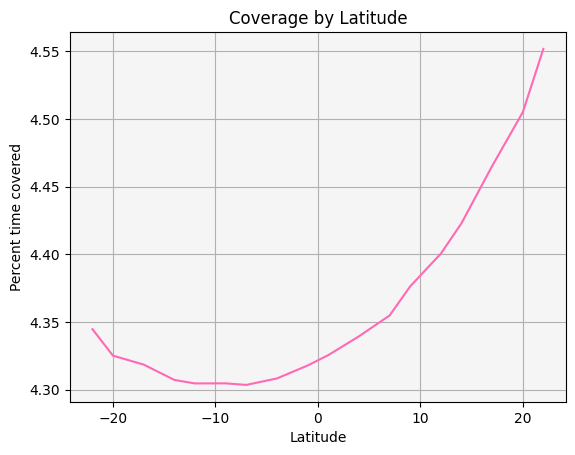

In [28]:
import matplotlib.pyplot as plt


ax = latitude_df.plot.line(x="latitude", y="percent time covered", color="hotpink")

# Configure the style of the plot
ax.get_legend().remove()
ax.set_facecolor("whitesmoke")
ax.grid(visible=True, which="both")

# Set title and axes labels
ax.set_title("Coverage by Latitude")
ax.set_xlabel("Latitude")
ax.set_ylabel("Percent time covered")

plt.show()

## Assess the quality of coverage

### Set the graphics

The Figure of Merit object has its own graphics which the Coverage Definition graphics interferes with. Thus, turn off the Show Regions and Show Points options of the Coverage Definition:

In [29]:
tropics.graphics.static.show_region = False
tropics.graphics.static.show_points = False

### Create a Figure of Merit

Create a Figure of Merit:

In [30]:
coverage = tropics.children.new(STKObjectType.FIGURE_OF_MERIT, "Coverage")

### Define the coverage

Set the coverage definition to N Asset Coverage:

In [31]:
from ansys.stk.core.stkobjects import FigureOfMeritDefinitionType


coverage.set_definition_type(FigureOfMeritDefinitionType.N_ASSET_COVERAGE)

Set the compute type to Maximum:

In [32]:
from ansys.stk.core.stkobjects import FigureOfMeritCompute


coverage.definition.set_compute_type(FigureOfMeritCompute.MAXIMUM)

### Configure the graphics

Set some animation graphics options for the Figure of Merit object:

In [33]:
from ansys.stk.core.stkobjects import FigureOfMeritGraphics2DAccumulation


coverage.graphics.animation_settings.show_graphics = True
coverage.graphics.animation_settings.accumulation = (
    FigureOfMeritGraphics2DAccumulation.CURRENT_TIME
)
coverage.graphics.animation_settings.fill_points = False
coverage.graphics.animation_settings.marker_style = "Star"

### Configure the static graphics

Set some static graphics options:

In [34]:
coverage.graphics.static.show_graphics = True
coverage.graphics.static.fill_points = False
coverage.graphics.static.marker_style = "Circle"

View the figure of merit using the 3D graphics window:

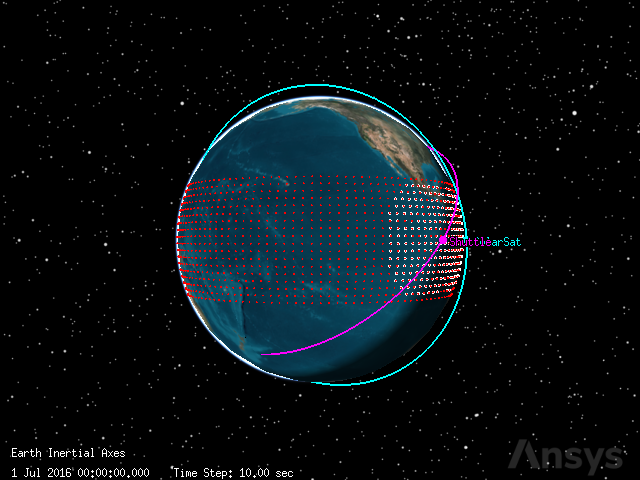

In [35]:
globe_plotter.show()

### Define the coverage for the Figure of Merit

Adjust the definition of the Figure of Merit's coverage to determine which points have coverage from both satellites at the same time:

In [36]:
from ansys.stk.core.stkobjects import FigureOfMeritSatisfactionType


coverage.definition.satisfaction.enable_satisfaction = True
coverage.definition.satisfaction.satisfaction_type = (
    FigureOfMeritSatisfactionType.AT_LEAST
)
coverage.definition.satisfaction.satisfaction_threshold = 2

The 3D Graphics window immediately reflects the reduction in the amount of the coverage region that satisfies the 'at least 2' criterion.

### Configure the animation graphics

Set some animation graphics to see when points are covered by neither, one, or both satellites:

In [37]:
from ansys.stk.core.stkobjects import FigureOfMeritGraphics2DColorMethod
from ansys.stk.core.utilities.colors import Color


coverage.graphics.static.show_graphics = False
coverage.graphics.animation_settings.contours.show_graphics = True
coverage.graphics.animation_settings.contours.color_method = (
    FigureOfMeritGraphics2DColorMethod.EXPLICIT
)
level1 = coverage.graphics.animation_settings.contours.level_attributes.add_level(1)
level1.color = Color.from_rgb(250, 7, 214)
level2 = coverage.graphics.animation_settings.contours.level_attributes.add_level(2)
level2.color = Color.from_rgb(45, 250, 195)

Animate the scenario:

In [38]:
root.rewind()

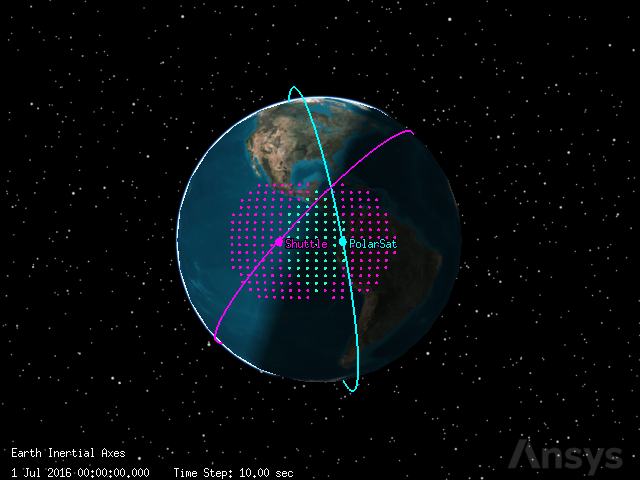

In [39]:
globe_plotter.camera.position = [-34200, -7780, 340]
globe_plotter.show()

In [40]:
root.play_forward()

Note that points are highlighted in pink when they are covered by only one satellite, and in blue when covered by both satellites.

### Create a Satisfied by Time report

The Satisfied by Time report summarizes the percentage and true area of the grid that satisfies the Figure Of Merit at each time step:

In [41]:
satisfied_by_time_result = coverage.data_providers.item("Satisfied by Time").execute(
    scenario.start_time, scenario.stop_time, 60.0
)
satisfied_by_time_df = satisfied_by_time_result.data_sets.to_pandas_dataframe()
satisfied_by_time_df

,time,percent satisfied,area satisfied,percent accum coverage,accum area coverage
0,1 Jul 2016 00:00:00.000000000,3.479722290551911,7090692.232415388,3.479722290551911,7090692.232415388
1,1 Jul 2016 00:01:00.000000000,4.382031771021817,8929344.369045507,4.572083389543204,9316615.944960214
2,1 Jul 2016 00:02:00.000000000,4.888604822780123,9961597.320094619,5.365667029969145,10933715.496329198
3,1 Jul 2016 00:03:00.000000000,5.108045699201793,10408755.911497833,6.067986007367905,12364843.414565872
4,1 Jul 2016 00:04:00.000000000,5.233103154517493,10663587.720754664,6.679608856079816,13611158.212245163
...,...,...,...,...,...
1436,1 Jul 2016 23:56:00.000000000,0.0,0.0,22.25567711958941,45350790.58104603
1437,1 Jul 2016 23:57:00.000000000,0.0,0.0,22.25567711958941,45350790.58104603
1438,1 Jul 2016 23:58:00.000000000,0.0,0.0,22.25567711958941,45350790.58104603
1439,1 Jul 2016 23:59:00.000000000,0.0,0.0,22.25567711958941,45350790.58104603


Visualize the data with a line chart:

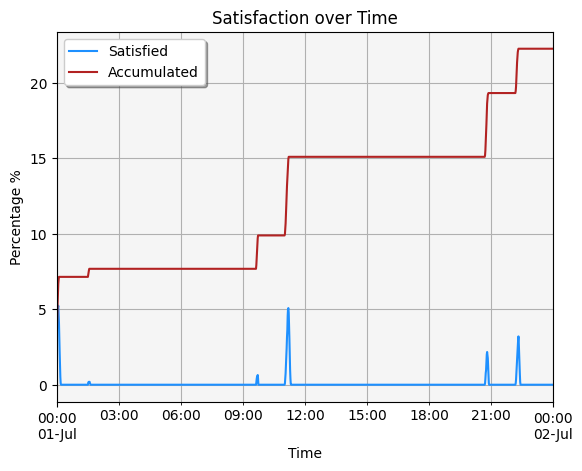

In [42]:
import pandas as pd


# convert data to correct types
satisfied_by_time_df["time"] = pd.to_datetime(satisfied_by_time_df["time"])
satisfied_by_time_df.set_index("time")
satisfied_by_time_df["percent satisfied"] = pd.to_numeric(
    satisfied_by_time_df["percent satisfied"]
)
satisfied_by_time_df["percent accum coverage"] = pd.to_numeric(
    satisfied_by_time_df["percent accum coverage"]
)

# Plot data
ax = satisfied_by_time_df.plot(
    x="time", y="percent satisfied", color="dodgerblue", label="Satisfied"
)
ax = satisfied_by_time_df.plot(
    x="time", y="percent accum coverage", color="firebrick", ax=ax, label="Accumulated"
)

# Set title and axes labels
ax.set_title("Satisfaction over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Percentage %")

# Configure style
ax.set_facecolor("whitesmoke")
ax.grid(visible=True, which="both")
ax.legend(shadow=True)

plt.show()